In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys
#sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/visualisation')
#import json_ImExport
import LogDataImport
import random
import matplotlib.pyplot as plt
#sys.path.insert(1,"/Users/leonkiesgen/Documents/Python/src/tqdm")

#import torch.utils.tensorboard import SummaryWriter


from tqdm.notebook import tqdm
import time

    
if torch.cuda.is_available() and True:
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")    
    
torch.manual_seed(0)

Running on the GPU


In [29]:
!nvidia-smi 

Der Befehl "nvidia-smi" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


## Data Import

In [42]:
with tqdm(total=2) as pbar:
    #Json
    #Jsondata=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")
    #Log File (Monteblanco)
    pbar.update(1)
    Logdata_MB=LogDataImport.get_data("15_00_59_data.csv")

    #Log File (Berlin)
    pbar.update(1)
    ValLogdata_B=LogDataImport.get_data("12_19_36_data.csv")

    #Log File (Modena)
    #pbar.update(1)
    #ValLogdata_M=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_41_27_data.csv")

    #Log File (zalazone)
    #pbar.update(1)
    #ValLogdata_Z=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_51_25_data.csv")

    #print(ValLogdata_Z)

## Define NN Model

In [43]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(RNN, self).__init__()
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.rnn= nn.RNN(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
        self.calcH = nn.RNN(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
    def forward(self,x,hidden):
        vini=x[:,0,:].squeeze()
        hidden=self.initHidden(x[:,0,:])
        #set_trace()
        r_out,hidden =self.rnn(x[:,1:,:],hidden)
        r_out=r_out.view(-1,2*self.hidden_dim)
        output = self.fc(r_out)

        return output
    
    def initHidden(self,vini):
        
        _,hidden=self.calcH(vini.unsqueeze(0),None)
        return hidden
    
    def zeroHidden(self):
        return torch.zeros(self.n_layers*2,1,self.hidden_dim)

In [44]:
class LSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(LSTM, self).__init__()
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.lstm= nn.LSTM(input_size,hidden_dim,n_layers,dropout=0.5,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
        self.calcH = nn.LSTM(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
    def forward(self,x,hidden):
        #vini=x[:,0,:].squeeze()
        #hidden=self.initHidden(x[:,0,:])
        #set_trace()
        r_out,hidden =self.lstm(x[:,1:,:],None)
        r_out=r_out.view(-1,2*self.hidden_dim)
        output = self.fc(r_out)

        return output
    
    def initHidden(self,vini):
        
        _,hidden=self.calcH(vini.unsqueeze(0),None)
        return hidden
    
    def zeroHidden(self):
        return torch.zeros(self.n_layers*2,1,self.hidden_dim)

## Data Preperation

In [45]:

model=RNN(input_size=1,output_size=1,hidden_dim=15,n_layers=2)
#tb= SummaryWriter()
#tb.add_graph(model)

class Normalize():

    def __init__(self,data,scale=None):

        if scale is None:
            self.max=np.max(np.abs(data))
        else:
            self.max=scale
        #print("Max is: ",self.max )

    def __call__(self,x):
        return x/self.max

    def normal(self,x):
        return x*self.max

# For Json
def prepareData(data):
    
    prepareddata=[]
    for item in data:

        #Input Data --------------------
        inpdata=[]
        inpdata.append(item["v_ini"])
        inpdata.append(item["v_max"])
        inpdata.append(item["Power"])   
        inpdata.extend(item["Kappa"])

        #Label Data -------------------
        label=item["V_op"]

        #Convert to Tensors -----------
        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(label)


        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    

    return prepareddata

# For Log File
def prepareLogData(indata):
    #lowestLen=200
    prepareddata=[]

    #Initialize Nomalizer
    #kappaNormalize=Normalize(allkappa)
    kappaNormalize=Normalize(None,scale=0.05)
    VelNormalize=Normalize(None,scale=70)
    data=[]
    for d in indata:
        data.extend(d)

    for item in data:
        inpdata=[]
        #lowestLen= len(item[1]) if len(item[1])< lowestLen else lowestLen

        #Input Data --------------------
        inpdata.append(VelNormalize(item[1][0]))
        kappatmp=np.array(item[0][:])
        kappatmp=kappaNormalize(kappatmp)
        inpdata.extend(kappatmp) #Kappa
        
        #Label Data -------------------
        label=np.array(item[1][:])

        #Convert to Tensors -----------
        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(VelNormalize(label))

        tupledata=(inpdata,label)
        
        #print(inpdata.shape,label.shape)
        
        prepareddata.append((inpdata,label))
        
    #print(lowestLen)
    return prepareddata

traindata=prepareLogData([Logdata_MB]) #[Logdata_MB,ValLogdata_M,ValLogdata_Z]
valdata=prepareLogData([ValLogdata_B[:250]])
#print(traindata[1])

random.shuffle(traindata)
random.shuffle(valdata)


inputT=torch.reshape(traindata[1][0],[-1,1]).unsqueeze(0)
print(inputT.shape)


#h0= torch.zeros((2,1,10))
h0=model.zeroHidden()
r_out= model(inputT,h0)

print(r_out.squeeze())

torch.Size([1, 106, 1])
tensor([-0.0966, -0.0137,  0.0537,  0.0723,  0.1011,  0.0999,  0.0988,  0.0954,
         0.0968,  0.0973,  0.0982,  0.0982,  0.0984,  0.0969,  0.0959,  0.0957,
         0.0958,  0.0960,  0.0961,  0.0963,  0.0964,  0.0965,  0.0966,  0.0967,
         0.0968,  0.0968,  0.0970,  0.0968,  0.0967,  0.0961,  0.0956,  0.0955,
         0.0954,  0.0954,  0.0953,  0.0953,  0.0953,  0.0952,  0.0952,  0.0951,
         0.0951,  0.0950,  0.0950,  0.0949,  0.0949,  0.0949,  0.0949,  0.0948,
         0.0948,  0.0947,  0.0947,  0.0946,  0.0946,  0.0945,  0.0944,  0.0944,
         0.0943,  0.0942,  0.0943,  0.0943,  0.0946,  0.0948,  0.0948,  0.0948,
         0.0948,  0.0948,  0.0948,  0.0949,  0.0949,  0.0949,  0.0949,  0.0949,
         0.0949,  0.0949,  0.0950,  0.0950,  0.0951,  0.0951,  0.0951,  0.0951,
         0.0952,  0.0952,  0.0952,  0.0952,  0.0952,  0.0953,  0.0953,  0.0953,
         0.0954,  0.0954,  0.0956,  0.0958,  0.0960,  0.0962,  0.0963,  0.0968,
         0.0968,

In [46]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.to(device)
num_epochs = 50
batchsize=len(traindata)
train_tracker, val_tracker, accuracy_tracker = [], [], []


for i in tqdm(range(num_epochs),desc="Total Progress: ",leave=False):
    
    cum_loss = 0
    random.shuffle(traindata)
    
    
    
    for batch,(inp, vel) in enumerate(tqdm(traindata,desc="Training Data",leave=False),1):

        
        inp=inp.reshape([1,-1,1])
        vel=vel.reshape([1,-1,1])
        inp=inp.to(device)
        
        hidden=model.zeroHidden()
        hidden=hidden.to(device)
        output= model(inp,hidden)

        output=output.view(-1,1)
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history


        outputVel=torch.reshape(vel,[-1,1])
        outputVel=outputVel.to(device)
        
        loss = criterion(output, outputVel)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    train_tracker.append(cum_loss/len(traindata))
    
    #Validation
    test_loss = 0
    num_correct = 0
    total = 0
    
    random.shuffle(valdata)
    with torch.no_grad():
        for batch, (inp, vel) in enumerate(tqdm(valdata,desc="Valiation Data", leave=False),1):

            optimizer.zero_grad()
            inp=inp.reshape([1,-1,1])
            inp=inp.to(device)
            
            output= model(inp,hidden)
            output=output.view(-1,1)
            
            outputVel=torch.reshape(vel,[-1,1])
            outputVel=outputVel.to(device)
            loss = criterion(output, outputVel)
            test_loss += loss

        val_tracker.append(test_loss/len(valdata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(traindata)} | " ,end="")
    print(f"Val loss: {test_loss/len(valdata)} | ")


Epoch(1/50) | Training loss: 0.09866506110263525 | Val loss: 0.18903903663158417 | 


Epoch(2/50) | Training loss: 0.07177376621871687 | Val loss: 0.11340292543172836 | 


Epoch(3/50) | Training loss: 0.06506194724375357 | Val loss: 0.07586740702390671 | 


Epoch(4/50) | Training loss: 0.06247910636253397 | Val loss: 0.09888609498739243 | 


Epoch(5/50) | Training loss: 0.06320233298559882 | Val loss: 0.09185101836919785 | 


Epoch(6/50) | Training loss: 0.06375816995109301 | Val loss: 0.09479069709777832 | 


Epoch(7/50) | Training loss: 0.09859167971808541 | Val loss: 0.13701578974723816 | 


Epoch(8/50) | Training loss: 0.08884668828980063 | Val loss: 0.09107271581888199 | 


Epoch(9/50) | Training loss: 0.07276696040154647 | Val loss: 0.1272590607404709 | 


Epoch(10/50) | Training loss: 0.06903416319285333 | Val loss: 0.09826982766389847 | 


Epoch(11/50) | Training loss: 0.06593178870274498 | Val loss: 0.13139702379703522 | 


Epoch(12/50) | Training loss: 0.06517164649930075 | Val loss: 0.10851728916168213 | 


Epoch(13/50) | Training loss: 0.06259013268725473 | Val loss: 0.0923096239566803 | 


Epoch(14/50) | Training loss: 0.06163550931890879 | Val loss: 0.14640042185783386 | 


Epoch(15/50) | Training loss: 0.05974148284320382 | Val loss: 0.11494824290275574 | 


Epoch(16/50) | Training loss: 0.058565481539595364 | Val loss: 0.08505348861217499 | 


Epoch(17/50) | Training loss: 0.05666214673217737 | Val loss: 0.08712823688983917 | 


Epoch(18/50) | Training loss: 0.06346918987264072 | Val loss: 0.12545394897460938 | 


Epoch(19/50) | Training loss: 0.06360732376392877 | Val loss: 0.09961030632257462 | 


Epoch(20/50) | Training loss: 0.06821259898051707 | Val loss: 0.10101430863142014 | 


Epoch(21/50) | Training loss: 0.06278661537675319 | Val loss: 0.09585210680961609 | 


Epoch(22/50) | Training loss: 0.05686840032945304 | Val loss: 0.09317507594823837 | 


Epoch(23/50) | Training loss: 0.055740137351552775 | Val loss: 0.12619076669216156 | 


Epoch(24/50) | Training loss: 0.05640143245884322 | Val loss: 0.08914199471473694 | 


Epoch(25/50) | Training loss: 0.063992334415637 | Val loss: 0.07949291169643402 | 


Epoch(26/50) | Training loss: 0.061486928696462814 | Val loss: 0.09308669716119766 | 


Epoch(27/50) | Training loss: 0.059024710776547314 | Val loss: 0.0858907476067543 | 


Epoch(28/50) | Training loss: 0.0560015221927702 | Val loss: 0.08194141834974289 | 


KeyboardInterrupt: 

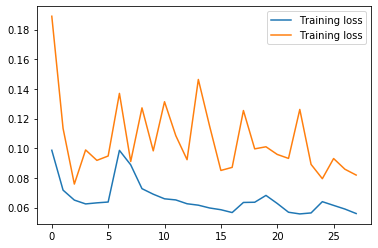

In [48]:
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(val_tracker, label='Training loss')
plt.legend()

In [49]:
def predict(testexample,NN=model):
    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()
    pData=testexample[0]
    pred=NN(pData[0])
    loss=criterion(pred,pData[1])

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(pData[1]))

    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    print("Loss:", loss.item())

from sklearn.metrics import r2_score
def Scoring(example,Score='MAE'):
    VelNormalize= Normalize(None,70)
    if Score=='MAE':
        criterion=nn.L1Loss()
    elif Score=="MSE":
        criterion=nn.MSELoss()
    elif Score=="R2":
        return
        PRED=[]
        REAL=[]
        with torch.no_grad():
            for (inp,label) in tqdm(example,leave=False):
                inp=torch.reshape(inp,[-1,1]).unsqueeze(0)
                inp=inp.to(device)
                hidden=model.zeroHidden()
                hidden=hidden.to(device)

                out=model(inp,hidden)

                label=label.to(device)
                out=out.squeeze()

                pred=torch.tensor(np.array(out.tolist()))
                real=torch.tensor(np.array(label.tolist()))

                PRED.append(pred.tolist())
                REAL.append(real.tolist())
        #set_trace()
        return r2_score(PRED,REAL,multioutput='variance_weighted')
    else: 
        print("Loss Function does not exist")
        return
    
    cumloss=0
    
    with torch.no_grad():
        for (inp,label) in tqdm(example,leave=False):

            inp=torch.reshape(inp,[-1,1]).unsqueeze(0)
            inp=inp.to(device)
            hidden=model.zeroHidden()
            hidden=hidden.to(device)
            out=model(inp,hidden)

            label=label.to(device)
            out=out.squeeze()

            pred=torch.tensor(VelNormalize.normal(np.array(out.tolist())))
            real=torch.tensor(VelNormalize.normal(np.array(label.tolist())))

            cumloss += criterion(pred,real)
        
    SCORE=cumloss/len(example)
    
    return SCORE.item()

In [51]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time


def visual(x):
    #The Visualisation
    name="NN300200150_Iter250_MBZM"
    NR=x
    
    VelNormalize= Normalize(None,70)
    
    #Loss Functions
    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()
    
    # Data
    testdata_inp,testdata_inp_V,testdata_lable,testdata_lable_V=[],[],[],[]
    
    testdata_inp=torch.clone(traindata[NR][0])
    testdata_inp_V=torch.clone(valdata[NR][0])
    
    testdata_lable=torch.clone(traindata[NR][1])
    testdata_lable_V=torch.clone(valdata[NR][1])
    

    
    #One Example
    inputRNN=torch.reshape(testdata_inp,[-1,1]).unsqueeze(0)
    inputRNN=inputRNN.to(device)
    
    t1=time.time()
    with torch.no_grad():
        hidden=model.zeroHidden()
        hidden=hidden.to(device)
        pred = model(inputRNN,hidden)
    t2=time.time()
    pred=pred.squeeze()
    print("Evolived Time: " , (t2-t1)*1000,"ms")
    testdata_lable=testdata_lable.to(device)
    loss=criterion(pred,testdata_lable)

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(testdata_lable.tolist()))
    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    plt.legend(["ML_Pred","Opt_Real"])
    plt.title("| "+name + " | Loss: "+str(np.round(loss.item(),4))+""+ " | " )
    plt.xlabel("Steps")
    plt.ylabel("Velocity")
    
    
    LossEval=True
    if LossEval:
        R2Score_T=Scoring(traindata,"R2")
        print("R2_T: " ,R2Score_T)
        R2Score_V=Scoring(valdata,"R2")
        print("R2_V: " ,R2Score_V)
        
        MAEScore_T=Scoring(traindata,"MAE")
        print("MAE_T: " ,MAEScore_T)
        MAEScore_V=Scoring(valdata,"MAE")
        print("MAE_V: " ,MAEScore_V)
        
        MSEScore_T=Scoring(traindata,"MSE")
        print("MSE_T: " ,MSEScore_T)
        MSEScore_V=Scoring(valdata,"MSE")
        print("MSE_V: " ,MSEScore_V)
        
        
        

    
    
    #scoreItem=r2_score(pred,valdata[NR][1])
    #text= str(np.round(scoreItem,4))+ "% [score] | "+str(np.round(loss.item(),5)) +" [loss] "
    MIN=min(pred)
    #plt.text(76,MIN,text,horizontalalignment='center',verticalalignment='center')
    #print("Loss:", loss.item())
    
    
    #print("The Score of the Train Dataset is: ",Score,"%")
    
interact(visual,x=(0,len(valdata)))

interactive(children=(IntSlider(value=125, description='x', max=250), Output()), _dom_classes=('widget-interac…

<function __main__.visual(x)>

## Save Model

In [36]:
name="BLSTM_1_15_2_Iter50_MB"
save=True
PATH= name

In [37]:
#Save MODEL
if save:
    torch.save(model.state_dict(), PATH+".pt")
    torch.save(model,PATH+".pth")

C:\Users\Leon\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Leon\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
#Load MODEL with same Structure
model=DNN()
model.load_state_dict(torch.load(PATH+".pt"))
model.eval()

In [ ]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

In [ ]:
model2(traindata[37][0])